In [21]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [22]:
# Loads train, validation, and test DataFrames for a given selector type
def load_data_for_selector(selector_type, base_path='processed_data/'):
    print(f"\n--- Loading data for selector: {selector_type} ---")
    try:
        train_df = pd.read_csv(os.path.join(base_path, f'train_{selector_type}.csv'))
        val_df = pd.read_csv(os.path.join(base_path, f'val_{selector_type}.csv'))
        test_df = pd.read_csv(os.path.join(base_path, f'test_{selector_type}.csv'))
        print("Train, Validation, and Test CSV files loaded successfully.")
        return train_df, val_df, test_df
    except FileNotFoundError as e:
        print(f"Error loading files for selector {selector_type}: {e}")
        print("Please ensure the CSV files exist in the 'processed_data' directory and are named correctly.")
        return None, None, None

In [23]:
# Extracts X (features) and y (labels) from the DataFrames
def extract_features_and_labels(train_df, val_df, test_df):
    print("\n--- Extracting Features and Labels ---")
    
    # Training data
    X_train = train_df.drop(columns=['image_path', 'ClassId'], errors='ignore')
    y_train = train_df['ClassId'] if 'ClassId' in train_df.columns else None
    print(f"X_train shape: {X_train.shape}")
    if y_train is not None:
        print(f"y_train shape: {y_train.shape}")
    else:
        print("y_train (ClassId) not found in train_df.")

    # Validation data
    X_val = val_df.drop(columns=['image_path', 'ClassId'], errors='ignore')
    y_val = val_df['ClassId'] if 'ClassId' in val_df.columns else None
    print(f"X_val shape: {X_val.shape}")
    if y_val is not None:
        print(f"y_val shape: {y_val.shape}")
    else:
        print("y_val (ClassId) not found in val_df.")

    X_test = test_df.drop(columns=['image_path', 'ClassId'], errors='ignore')
    print(f"X_test shape: {X_test.shape}")
    
    return X_train, y_train, X_val, y_val, X_test

## Data Sanity Check

In [24]:
# Checks and prints shapes and compares feature headers
def check_shapes_and_headers(X_train, X_val, X_test, train_df, val_df, test_df):
    print("\n--- Checking Shapes and Headers ---")
    print(f"Raw train_df shape: {train_df.shape}")
    print(f"Raw val_df shape: {val_df.shape}")
    print(f"Raw test_df shape: {test_df.shape}")

    print(f"\nFeatures X_train shape: {X_train.shape}")
    print(f"Features X_val shape: {X_val.shape}")
    print(f"Features X_test shape: {X_test.shape}")

    if not (X_train.shape[1] == X_val.shape[1] == X_test.shape[1]):
        print("\nWARNING: Number of feature columns differs between train, val, and test sets!")
    else:
        print("\nNumber of feature columns is consistent across X_train, X_val, X_test.")

    train_cols = set(X_train.columns)
    val_cols = set(X_val.columns)
    test_cols = set(X_test.columns)

    if train_cols == val_cols == test_cols:
        print("Feature column names are consistent across X_train, X_val, X_test.")
    else:
        print("\nWARNING: Feature column names differ between sets!")
        if train_cols != val_cols:
            print(f"Difference (train vs val): {train_cols.symmetric_difference(val_cols)}")
        if train_cols != test_cols:
            print(f"Difference (train vs test): {train_cols.symmetric_difference(test_cols)}")
        if val_cols != test_cols:
            print(f"Difference (val vs test): {val_cols.symmetric_difference(test_cols)}")
    return X_train.columns # Return feature columns for later use

In [25]:
# Checks for missing values in X_train, X_val, X_test
# datasets_dict is a dictionary like {'X_train': X_train_df, ...}
def check_missing_values(datasets_dict):
    print("\n--- Checking Missing Values (NaNs) in Feature Sets ---")
    for name, df in datasets_dict.items():
        if df is None or df.empty:
            print(f"{name} is empty or None. Skipping NaN check.")
            continue
        nan_counts = df.isnull().sum()
        total_nans = nan_counts.sum()
        if total_nans > 0:
            print(f"\nWARNING: Missing values found in {name}:")
            print(nan_counts[nan_counts > 0])
        else:
            print(f"\nNo missing values found in {name}.")

In [26]:
# Compares descriptive statistics for each feature across datasets
def compare_feature_statistics(X_train, X_val, X_test, feature_cols):
    print("\n--- Comparing Feature Statistics (Mean, Std, Min, Max) ---")
    
    stats_list = []
    for col in feature_cols:
        if col in X_train and col in X_val and col in X_test:
            stats_list.append({
                'Feature': col,
                'Train_Mean': X_train[col].mean(), 'Val_Mean': X_val[col].mean(), 'Test_Mean': X_test[col].mean(),
                'Train_Std': X_train[col].std(), 'Val_Std': X_val[col].std(), 'Test_Std': X_test[col].std(),
                'Train_Min': X_train[col].min(), 'Val_Min': X_val[col].min(), 'Test_Min': X_test[col].min(),
                'Train_Max': X_train[col].max(), 'Val_Max': X_val[col].max(), 'Test_Max': X_test[col].max(),
            })
        else:
            print(f"Warning: Feature '{col}' not present in all sets for stats comparison.")

    if not stats_list:
        print("No common features to compare statistics for.")
        return None
        
    stats_df = pd.DataFrame(stats_list)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(stats_df.to_string(index=False))
    return stats_df

In [27]:
# Plots the means of features across train, val, and test set
def plot_feature_means(stats_df, selector_type, num_features_to_plot=30):
    if stats_df is None or stats_df.empty:
        print("No statistics DataFrame to plot.")
        return

    # Select a subset of features to plot if there are too many
    if len(stats_df) > num_features_to_plot:
        print(f"\nPlotting means for the first {num_features_to_plot} features (out of {len(stats_df)}).")
        stats_to_plot = stats_df.head(num_features_to_plot)
    else:
        stats_to_plot = stats_df

    plot_df = stats_to_plot.melt(id_vars=['Feature'], 
                                 value_vars=['Train_Mean', 'Val_Mean', 'Test_Mean'],
                                 var_name='Dataset', value_name='Mean')
    
    plt.figure(figsize=(15, max(8, len(stats_to_plot) * 0.4))) # Adjust height based on num features
    sns.barplot(x='Mean', y='Feature', hue='Dataset', data=plot_df, palette={'Train_Mean':'blue', 'Val_Mean':'orange', 'Test_Mean':'green'})
    plt.title(f'Comparison of Feature Means ({selector_type} selection) - Top {len(stats_to_plot)} features')
    plt.tight_layout()

In [28]:
# Compares ClassId distributions in train and validation sets
def compare_class_distributions(y_train, y_val):
    print("\n--- Comparing Class Distributions (ClassId) ---")
    if y_train is not None:
        print("\nTraining Set Class Distribution:")
        print(y_train.value_counts(normalize=True).sort_index())
    else:
        print("y_train is None, cannot show class distribution.")
        
    if y_val is not None:
        print("\nValidation Set Class Distribution:")
        print(y_val.value_counts(normalize=True).sort_index())
    else:
        print("y_val is None, cannot show class distribution.")

## Main Function

In [29]:
def run_data_check(selector_type):
    train_df, val_df, test_df = load_data_for_selector(selector_type)
    if train_df is None: # Loading failed
        return

    X_train, y_train, X_val, y_val, X_test = extract_features_and_labels(train_df, val_df, test_df)
    
    # Ensure all feature sets are not empty before proceeding
    if X_train.empty or X_val.empty or X_test.empty:
        print("One or more feature sets (X_train, X_val, X_test) are empty. Aborting further checks for this selector.")
        return

    feature_cols = check_shapes_and_headers(X_train, X_val, X_test, train_df, val_df, test_df)
    
    datasets_to_check_nans = {'X_train': X_train, 'X_val': X_val, 'X_test': X_test}
    check_missing_values(datasets_to_check_nans)
    
    stats_comparison_df = compare_feature_statistics(X_train, X_val, X_test, feature_cols)
    
    if stats_comparison_df is not None:
        plot_feature_means(stats_comparison_df, selector_type)
        
    compare_class_distributions(y_train, y_val)
    
    print(f"\n--- Finished checks for selector: {selector_type} ---")


--- Loading data for selector: rf ---
Train, Validation, and Test CSV files loaded successfully.

--- Extracting Features and Labels ---
X_train shape: (4390, 32)
y_train shape: (4390,)
X_val shape: (1098, 32)
y_val shape: (1098,)
X_test shape: (2353, 32)

--- Checking Shapes and Headers ---
Raw train_df shape: (4390, 34)
Raw val_df shape: (1098, 34)
Raw test_df shape: (2353, 34)

Features X_train shape: (4390, 32)
Features X_val shape: (1098, 32)
Features X_test shape: (2353, 32)

Number of feature columns is consistent across X_train, X_val, X_test.
Feature column names are consistent across X_train, X_val, X_test.

--- Checking Missing Values (NaNs) in Feature Sets ---

No missing values found in X_train.

No missing values found in X_val.

No missing values found in X_test.

--- Comparing Feature Statistics (Mean, Std, Min, Max) ---
                   Feature  Train_Mean  Val_Mean     Test_Mean  Train_Std   Val_Std  Test_Std  Train_Min   Val_Min  Test_Min  Train_Max    Val_Max   T

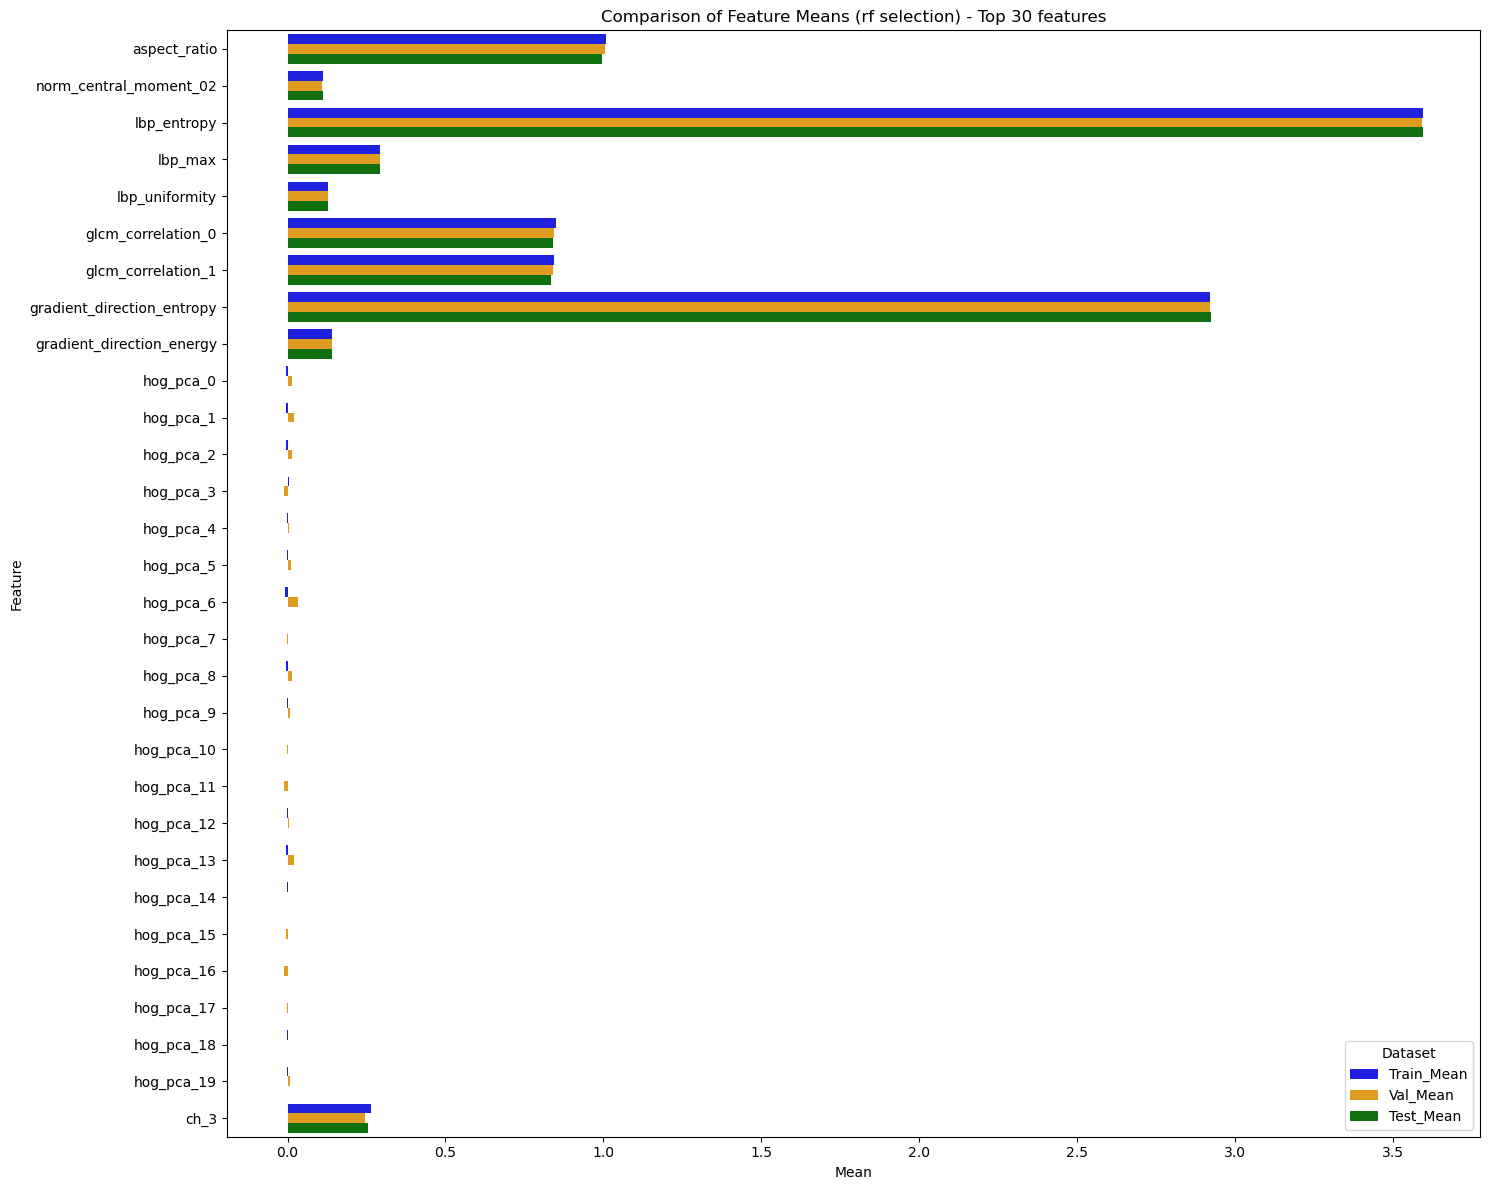

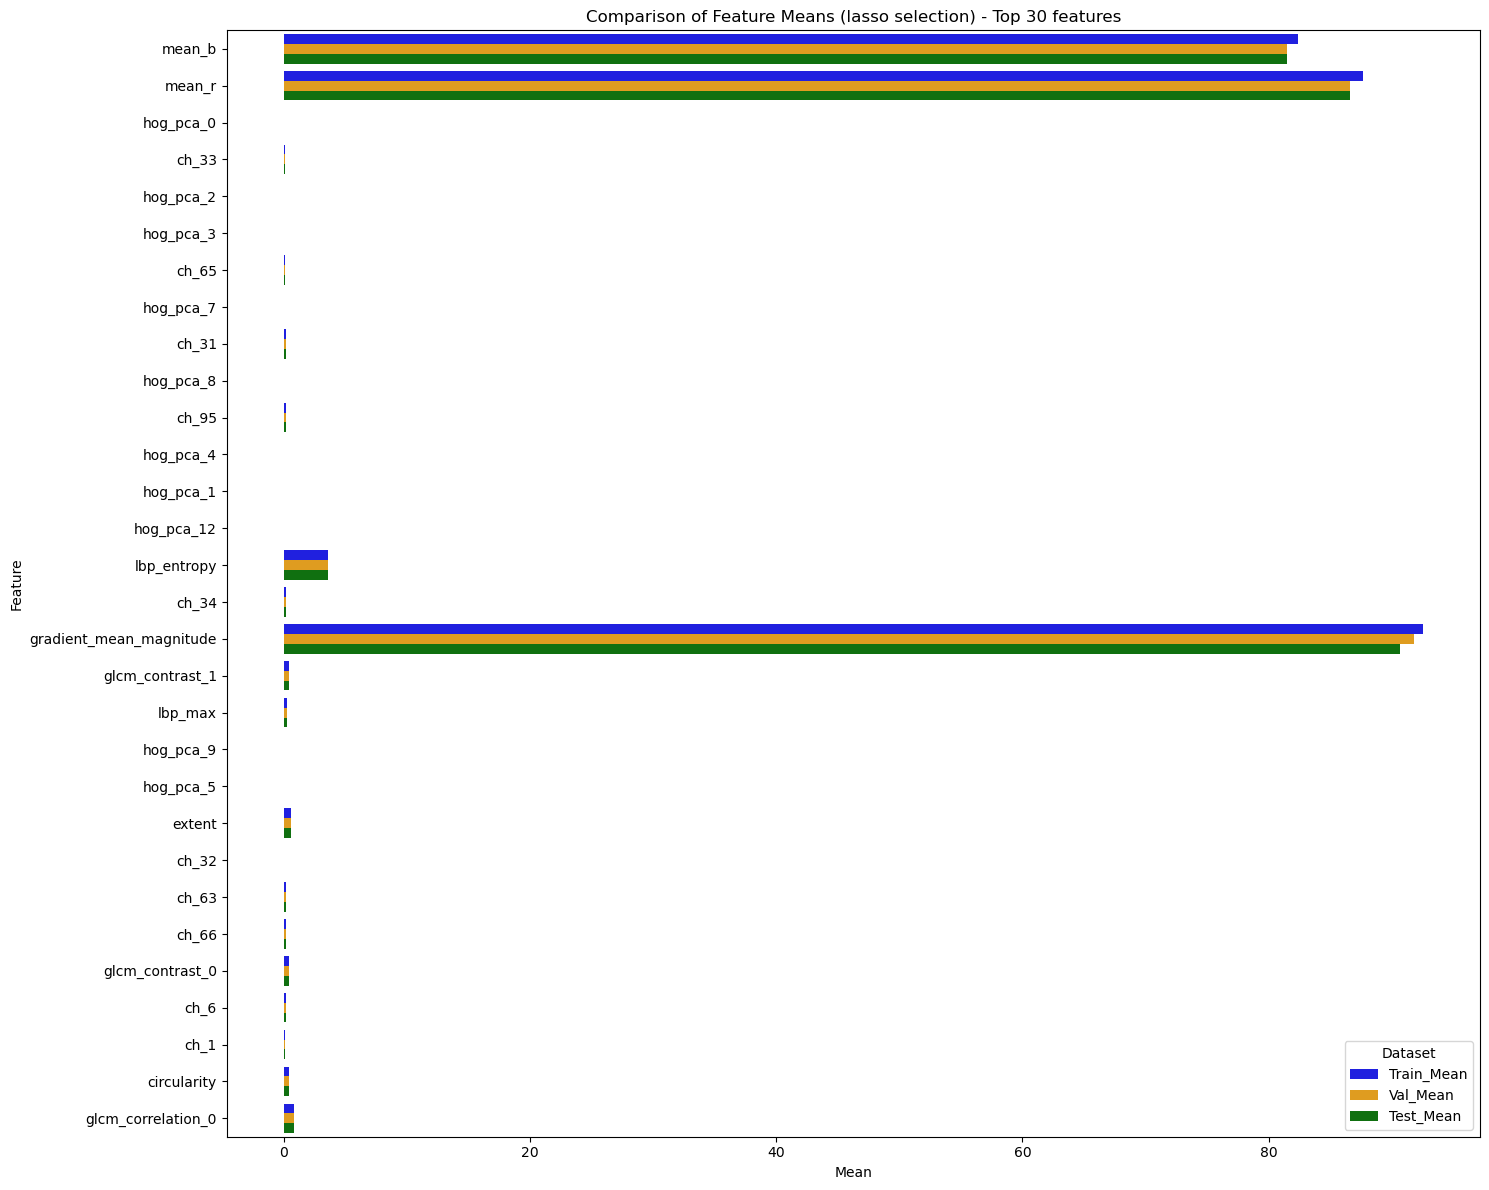

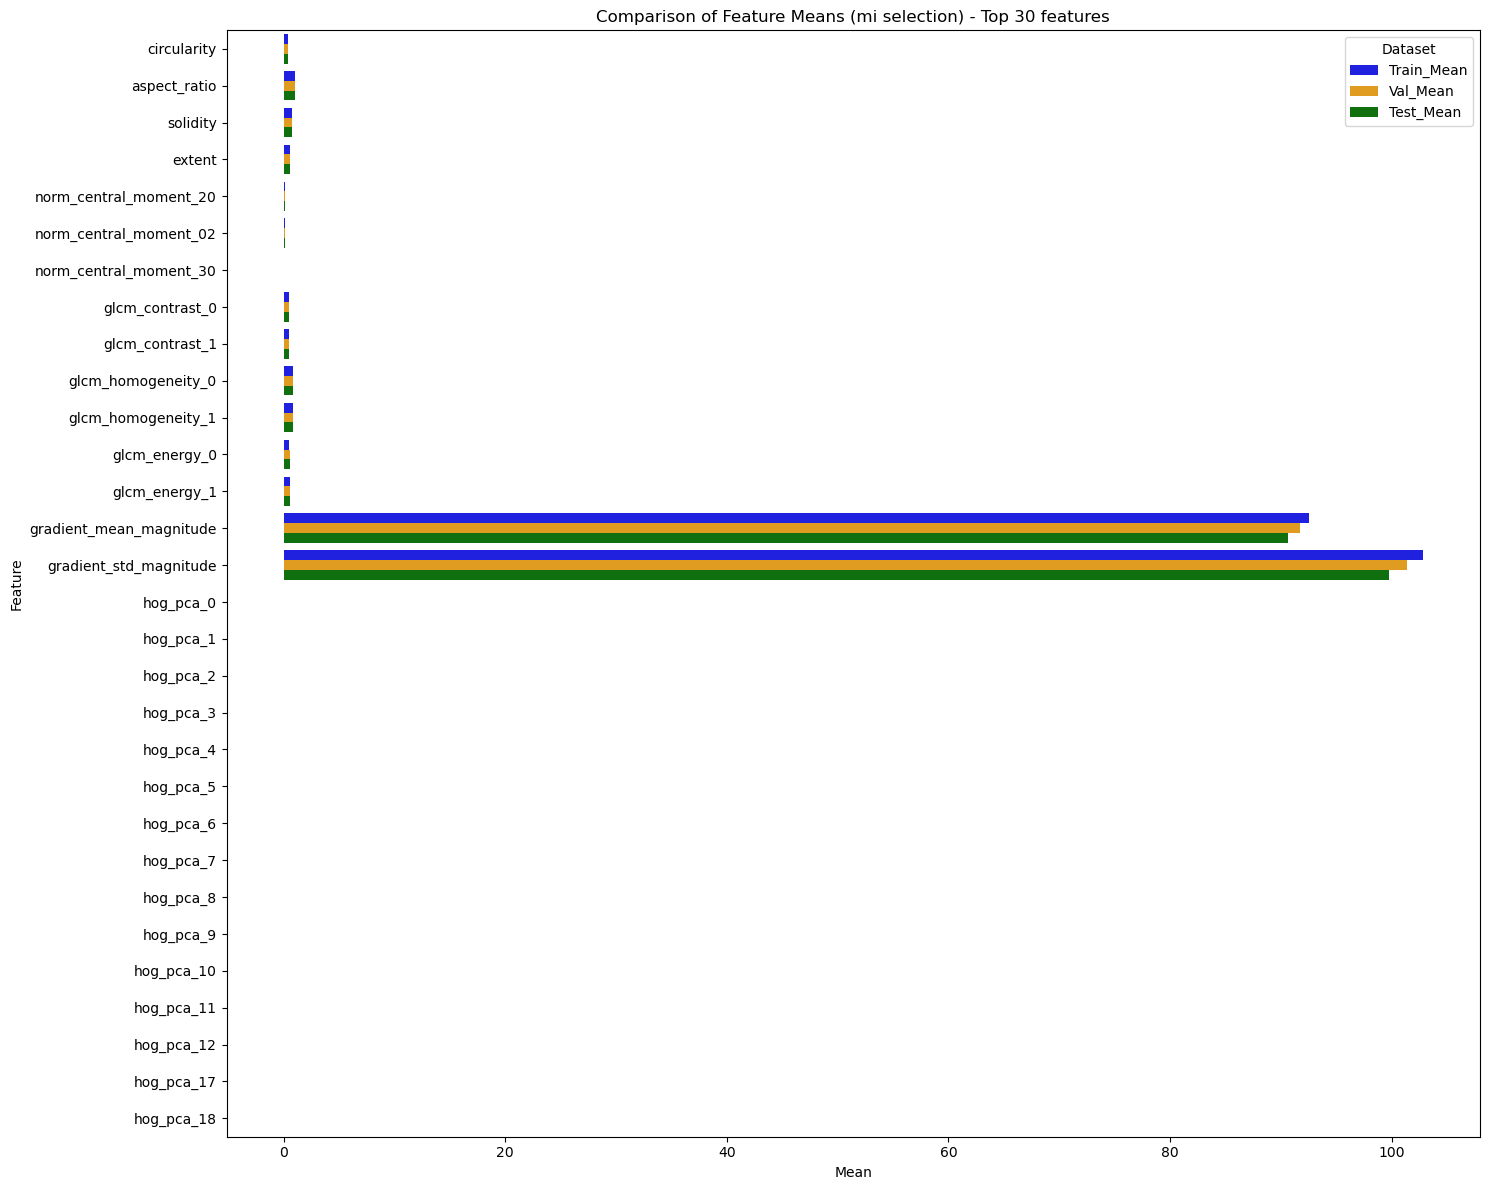

In [30]:
selector_types = ['rf', 'lasso', 'mi']
for fs_method in selector_types:
    run_data_check(fs_method)
    print("\n" + "="*80 + "\n")